In [1]:
import pickle
from detectors import *
import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
def time_fit(det, data, labels):
    time_begin = time.time()
        
    det = det.fit(np.array(data), targets=np.array(labels))
    
    return det, time.time() - time_begin

def time_test(det, data):
    time_begin = time.time()
        
    result = det.predict_proba(np.array(data))
    
    return det, time.time() - time_begin, result


# load data

In [3]:
permutations = 10
modes = ['bert_768', 'bow_50', 'bow_768']
subsets = {}

result_pickle = 'data/results/twitter_drift_induction.pickle'

for mode in modes:
    with open('data/twitter/twitter_{mode}_drift.pickle'.format(mode=mode), 'rb') as handle:
        subsets[mode] = gradual_dict = pickle.load(handle)
        
target_percentages = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

# initiate detectors

In [4]:
detectors = {
    'csdd': CosineSimilarityDriftDetector(),
    'kts' : KernelTwoSampleDriftDetector(),
    'aks' : AlibiKSDetector(),
    'ammd': AlibiMMDDetector(),
    'lsdd': AlibiLSDDDetector(),
    'cdbd': CDBDDetector()
}


# tests

In [5]:
if os.path.isfile(result_pickle):  # Do not overwrite
    print('Loading result pickle: ', result_pickle)
    with open(result_pickle, 'rb') as handle:
        results = pickle.load(handle)
else:
    results = {mode: {detector: {} for detector in detectors} for mode in modes}
    

for mode in modes:
    # generating permutations
    gradual_dict_orig = [[x for x in subsets[mode]['orig'][0][i::permutations]] for i in range(permutations)]
    gradual_dict_label = [int(x//(len(gradual_dict_orig[0])/2)) for x in range(len(gradual_dict_orig[0]))]
    gradual_dict_drifted = [[] for i in range(permutations)]
    for percentage in subsets[mode]['drifted'][0]:
        sliced = [[x for x in percentage[i::permutations]] for i in range(permutations)]
        for i in range(permutations):
            gradual_dict_drifted[i].append(sliced[i])
        
    
    for detector in detectors:
        if not detector in results[mode]:
            results[mode][detector] = {}
        if 'predictions' in results[mode][detector]: # skip already computed
            continue
        
        results[mode][detector]['predictions'] = {i: [] for i in range(len(gradual_dict_orig))}
        results[mode][detector]['time_detect'] = {i: [] for i in range(len(gradual_dict_orig))}
        
        for permutation in range(permutations):
        
            det, t = time_fit(detectors[detector],
                              gradual_dict_orig[permutation],
                              gradual_dict_label)
            results[mode][detector]['time_fit'] = t

            for percentage in gradual_dict_drifted[permutation]:
                det_2, t, res = time_test(det, percentage)
                results[mode][detector]['predictions'][permutation].append(res)
                results[mode][detector]['time_detect'][permutation].append(t)

with open(result_pickle, 'wb') as handle:
    pickle.dump(results, handle)
    

Loading result pickle:  data/results/twitter_drift_induction.pickle


/home/rfeldhans/.local/lib/python3.8/site-packages/alibi_detect/utils/pytorch/distance.py:143: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  lam_index = (rds < lam_rd_max).nonzero()[0]


# plot graphs

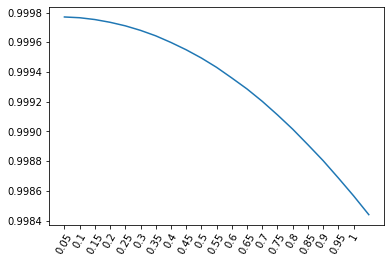

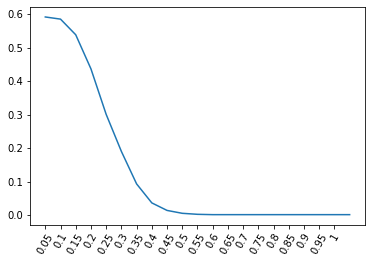

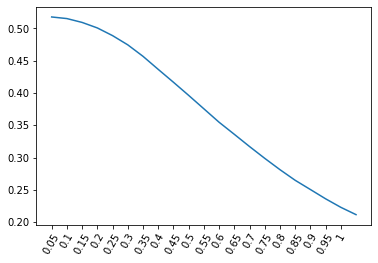

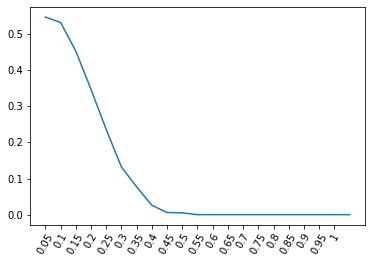

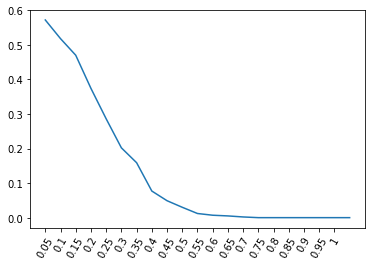

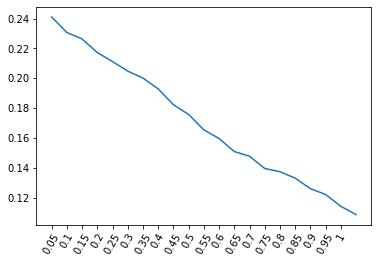

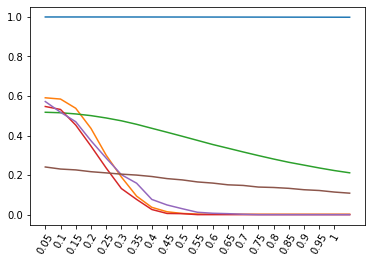

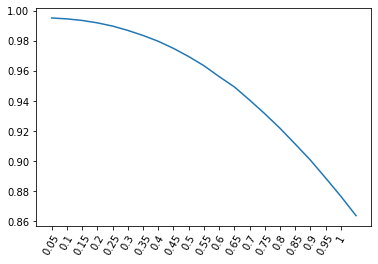

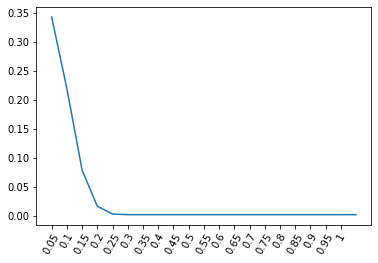

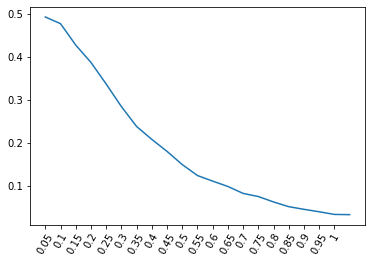

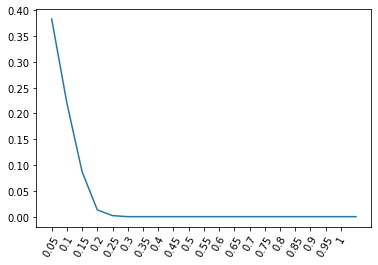

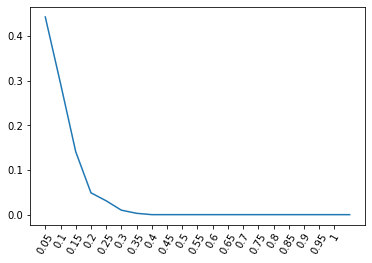

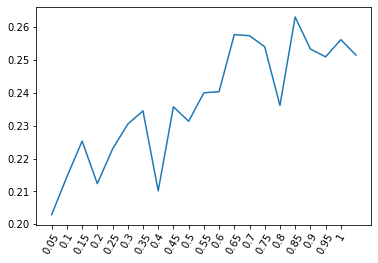

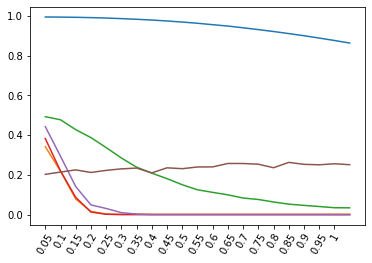

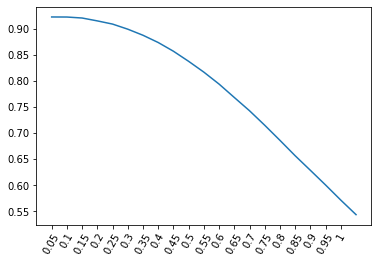

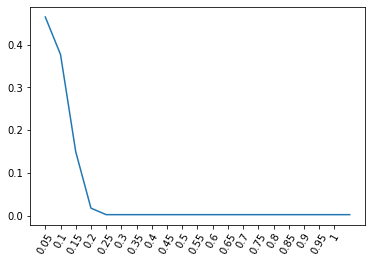

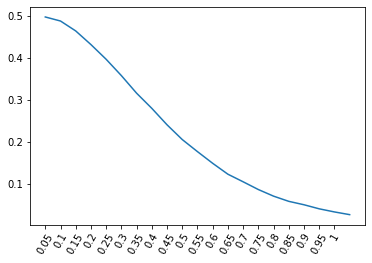

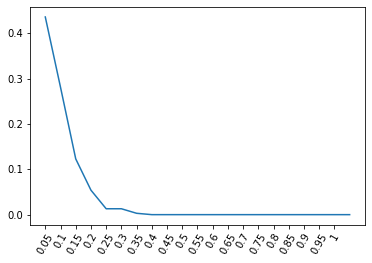

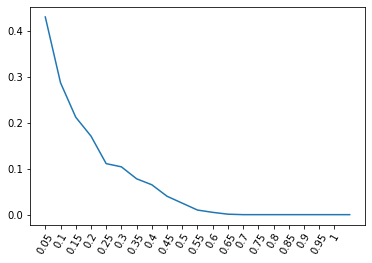

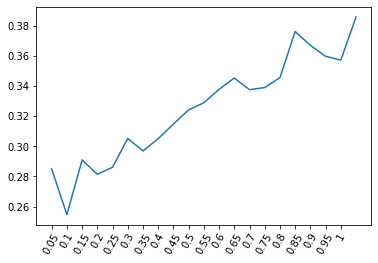

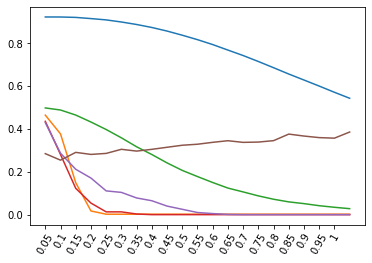

In [6]:
for mode in modes:
    for detector in detectors:
        means = []
        for n in range(len(results[mode][detector]['predictions'][0])):
            nth_entries = [results[mode][detector]['predictions'][i][n] for i in range(permutations)]
            means.append(np.mean(nth_entries))
            
        plt.plot(means)
        plt.xticks(ticks=np.arange(len(target_percentages)), labels=target_percentages, rotation=60)
        plt.savefig('figures/by_dataset/twitter_{mode}_drift_induction_{detector}.pdf'.format(mode=mode, detector=detector), format='pdf')
        plt.show()
        
    for detector in detectors:
        means = []
        for n in range(len(results[mode][detector]['predictions'][0])):
            nth_entries = [results[mode][detector]['predictions'][i][n] for i in range(permutations)]
            means.append(np.mean(nth_entries))
            
        plt.plot(means)
    plt.xticks(ticks=np.arange(len(target_percentages)), labels=target_percentages, rotation=60)
    plt.savefig('figures/by_dataset/twitter_{mode}_drift_induction_all.pdf'.format(mode=mode), format='pdf')
    plt.show()

In [7]:
print(results)

{'bert_768': {'csdd': {'predictions': {0: [0.9997335, 0.9997289, 0.9997204, 0.99969316, 0.9996654, 0.99962527, 0.9995857, 0.99953187, 0.9994762, 0.9994165, 0.99936616, 0.9992966, 0.9992076, 0.9991317, 0.999061, 0.99895114, 0.9988597, 0.9987446, 0.9986187, 0.9985003, 0.99838483], 1: [0.9997165, 0.9997045, 0.9996883, 0.99965805, 0.99962753, 0.99959743, 0.99955577, 0.99950767, 0.9994534, 0.9993946, 0.9993261, 0.9992428, 0.99916404, 0.999073, 0.99899083, 0.9989102, 0.9987848, 0.9986805, 0.9985776, 0.99847806, 0.9983468], 2: [0.9997269, 0.99972683, 0.99971634, 0.9997061, 0.9996897, 0.9996668, 0.9996342, 0.9995986, 0.9995478, 0.999488, 0.99944186, 0.99936926, 0.99929756, 0.99922955, 0.9991521, 0.9990519, 0.9989534, 0.9988443, 0.9987356, 0.99861467, 0.9984743], 3: [0.9997784, 0.9997699, 0.99975276, 0.99973106, 0.9997086, 0.9996699, 0.9996336, 0.9995891, 0.9995448, 0.9994941, 0.99941224, 0.99932617, 0.9992565, 0.9991754, 0.99908715, 0.9990036, 0.9988885, 0.9987964, 0.99867296, 0.9985436, 0.998